In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


# Create Slice Manager Object

Users can request tokens with different Project and Scopes by altering project_name and scope parameters in the refresh call below.

In [3]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

## Orchestrator API example to query for available resources

In [4]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL: { cpu: 6/6 , core: 184/192 , ram: 1,492/1,536 G, disk: 9,380/9,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
	Site Interfaces:
RENC
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
STAR
	Components:
	Site Interfaces:
UKY: { cpu: 6/6 , core: 190/192 , ram: 1,530/1,536 G, disk: 9,590/9,600 G, unit: 3/3 }
	Components:
		GPU-RTX6000:  GPU 

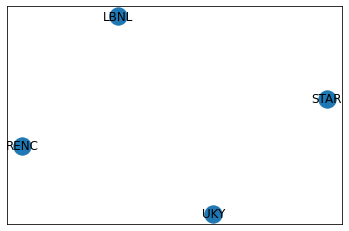

In [5]:
if status == Status.OK:
    advertised_topology.draw()

# Create Slice

In [6]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='LBNL')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Shared Cards
n1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name='n2-nic1')


# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/julin/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='iperf-test', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "42e316b8-a355-40f4-b1b1-21bf241f2a13",
    "lease_end": "2021-08-25 18:14:27",
    "pending_state": "None_",
    "reservation_id": "446658a9-8e39-4b29-8cdb-086c51b9ebee",
    "reservation_state": "Unknown",
    "slice_id": "3d008d01-713a-4319-ae67-192843ea592b"
}, {
    "graph_node_id": "2e24dac6-e631-4548-b831-39bc70478a11",
    "lease_end": "2021-08-25 18:14:27",
    "pending_state": "None_",
    "reservation_id": "879ca08b-0b68-401b-ad79-6c26b08d412f",
    "reservation_state": "Unknown",
    "slice_id": "3d008d01-713a-4319-ae67-192843ea592b"
}]


In [7]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

# Qurey slice

In [8]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "1693df55-d626-4f32-b3b7-5137d456d574",
    "lease_end": "2021-08-25 16:26:33",
    "slice_id": "a9c97e88-2dd8-4d3b-9b8a-350225350d15",
    "slice_name": "hello-fabric",
    "slice_state": "Dead"
}, {
    "graph_id": "ddc27c6b-b69f-4e0b-ba6a-61790304a57c",
    "lease_end": "2021-08-25 17:48:29",
    "slice_id": "531474fe-58a2-4196-95d7-0631e5a6a5a7",
    "slice_name": "hello-fabric",
    "slice_state": "StableOK"
}, {
    "graph_id": "730dcf8e-c0d0-48f5-af8b-dab06db7aa20",
    "lease_end": "2021-08-25 17:49:49",
    "slice_id": "d0d27904-65b9-4d55-a401-c1a2dca60389",
    "slice_name": "hello-fabric_jl",
    "slice_state": "StableOK"
}, {
    "graph_id": "277e6d09-494b-4a42-9f90-9164d199b74b",
    "lease_end": "2021-08-25 17:58:33",
    "slice_id": "34c97cb4-93b2-4519-8cc0-ed9417f9d530",
    "slice_name": "my_simple_slice",
    "slice_state": "Dead"
}, {
    "graph_id": "5837c243-2f4b-4aa9-afa6-affea5a7052f",
    "lease_end": "2021-08-

# Query Slivers

In [9]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-0000015f\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "2e24dac6-e631-4548-b831-39bc70478a11",
    "join_state": "NoJoin",
    "lease_end": "2021-08-25 18:14:27",
    "management_ip": "198.129.61.55",
    "name": "n2",
    "pending_state": "None_",
    "reservation_id": "879ca08b-0b68-401b-ad79-6c26b08d412f",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "3d008d01-713a-4319-ae67-192843ea592b"
}, {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000160\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"dis

In [11]:
server_ip = slivers[0].management_ip
server_ip

'198.129.61.55'

In [12]:
client_ip = slivers[1].management_ip
client_ip

'198.129.61.41'

In [14]:
import paramiko 
#from scp import SCPClient, SCPException

key = paramiko.RSAKey.from_private_key_file("/home/julin/.ssh/id_rsa")
client_server = paramiko.SSHClient()
client_server.load_system_host_keys()
client_server.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client_server.set_missing_host_key_policy(paramiko.AutoAddPolicy())

In [22]:
# install iperf package
client_server.connect(server_ip,username='centos',pkey = key)
stdin, stdout, stderr = client_server.exec_command('sudo yum install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Last metadata expiration check: 0:04:12 ago on Tue 24 Aug 2021 06:33:35 PM UTC.
Dependencies resolved.
 Package             Architecture  Version               Repository        Size
Installing:
 iperf3              x86_64        3.5-6.el8             appstream        100 k
Installing dependencies:
 lksctp-tools        x86_64        1.0.18-3.el8          baseos           100 k

Transaction Summary
Install  2 Packages

Total download size: 200 k
Installed size: 481 k
(1/2): iperf3-3.5-6.el8.x86_64.rpm              215 kB/s | 100 kB     00:00    
(2/2): lksctp-tools-1.0.18-3.el8.x86_64.rpm     176 kB/s | 100 kB     00:00    
--------------------------------------------------------------------------------
Total                                           161 kB/s | 200 kB     00:01     
CentOS Linux 8 - AppStream                      1.6 MB/s | 1.6 kB     00:00    
Key imported successfully
Running transaction check
Transaction check succeeded.
Running transaction test
Transaction test succ

In [32]:
# server side run iperf
# print('iperf3 -s -B ' + server_ip)
#stdin, stdout, stderr = client_server.exec_command('iperf3 -s ' + server_ip)
client_server.exec_command('iperf3 -s ' + server_ip)
# print ('')
# print (str(stdout.read(),'utf-8').replace('\\n','\n'))
# print (str(stderr.read(),'utf-8').replace('\\n','\n'))

(<paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0x486ea5e0 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>,
 <paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0x486ea5e0 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>,
 <paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0x486ea5e0 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>)

In [37]:
# clinet side
key = paramiko.RSAKey.from_private_key_file("/home/julin/.ssh/id_rsa")
client_client = paramiko.SSHClient()
client_client.load_system_host_keys()
client_client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client_client

In [40]:
# install iperf package
client_client.connect(client_ip,username='centos',pkey = key)
stdin, stdout, stderr = client_client.exec_command('sudo yum install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

CentOS Linux 8 - AppStream                      4.9 MB/s | 8.8 MB     00:01    
CentOS Linux 8 - BaseOS                         2.6 MB/s | 5.6 MB     00:02    
CentOS Linux 8 - Extras                          20 kB/s |  10 kB     00:00    
Last metadata expiration check: 0:00:01 ago on Tue 24 Aug 2021 07:01:06 PM UTC.
Dependencies resolved.
 Package             Architecture  Version               Repository        Size
Installing:
 iperf3              x86_64        3.5-6.el8             appstream        100 k
Installing dependencies:
 lksctp-tools        x86_64        1.0.18-3.el8          baseos           100 k

Transaction Summary
Install  2 Packages

Total download size: 200 k
Installed size: 481 k
(1/2): iperf3-3.5-6.el8.x86_64.rpm              253 kB/s | 100 kB     00:00    
(2/2): lksctp-tools-1.0.18-3.el8.x86_64.rpm     133 kB/s | 100 kB     00:00    
--------------------------------------------------------------------------------
Total                                           

In [42]:
stdin, stdout, stderr  = client_client.exec_command('iperf3 -c ' + server_ip)
print ('')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
print (str(stderr.read(),'utf-8').replace('\\n','\n'))


Connecting to host 198.129.61.55, port 5201
[  5] local 10.20.4.132 port 52138 connected to 198.129.61.55 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec  1.11 GBytes  9.56 Gbits/sec    2   3.01 MBytes       
[  5]   1.00-2.00   sec  1.14 GBytes  9.79 Gbits/sec    0   3.01 MBytes       
[  5]   2.00-3.00   sec  1.13 GBytes  9.68 Gbits/sec    0   3.01 MBytes       
[  5]   3.00-4.00   sec  1.14 GBytes  9.77 Gbits/sec    0   3.01 MBytes       
[  5]   4.00-5.00   sec  1.14 GBytes  9.81 Gbits/sec    0   3.01 MBytes       
[  5]   5.00-6.00   sec  1.13 GBytes  9.67 Gbits/sec    0   3.01 MBytes       
[  5]   6.00-7.00   sec  1.15 GBytes  9.86 Gbits/sec    0   3.01 MBytes       
[  5]   7.00-8.00   sec  1.13 GBytes  9.73 Gbits/sec   38   3.01 MBytes       
[  5]   8.00-9.00   sec  1.13 GBytes  9.71 Gbits/sec   11   3.01 MBytes       
[  5]   9.00-10.00  sec  1.12 GBytes  9.62 Gbits/sec    0   3.01 MBytes       
- - - - - - - - - - - - - - 

# Delete Slice

In [43]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
